In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import re

# the below extension properly formats a cell after it is run
%load_ext nb_black 

# Set the maximum number of rows to 200
pd.set_option("display.max_rows", 200)


# Set the maximum number of columns to 200
pd.set_option('display.max_columns', 200)


<IPython.core.display.Javascript object>

In [246]:
# loading the csv that contains addresses so i can get lat and lon
real_estate = pd.read_csv("data/Ames_Real_Estate_Data.csv", index_col=0)


/var/folders/37/_6bzmbwj16q021_3f7fq4yv40000gp/T/ipykernel_2542/4073422877.py:2: DtypeWarning: Columns (36,40,81,87) have mixed types. Specify dtype option on import or set low_memory=False.
  real_estate = pd.read_csv("data/Ames_Real_Estate_Data.csv", index_col=0)


<IPython.core.display.Javascript object>

In [247]:
# Loading the housing_no_na csv
housing = pd.read_csv("data/housing_no_na.csv")


<IPython.core.display.Javascript object>

In [248]:
# Select columns from the housing and real_estate dataframes and merge them
locations = housing[["PID", "SalePrice", "Neighborhood"]].merge(
    real_estate[["GeoRefNo", "Prop_Addr"]],
    left_on="PID",
    right_on="GeoRefNo",
    how="left",
)

# Drop the redundant column GeoRefNo
locations.drop("GeoRefNo", axis=1, inplace=True)

# Add the city and state to the property address
locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: f"{x}, AMES, USA" if isinstance(x, str) else None
)

# The above code added duplicates since they were in the real_estate csv so this will remove them
locations.drop_duplicates(subset=["PID"], keep="first", inplace=True)

locations

PID  SalePrice Neighborhood                       Prop_Addr
0     909176150     126000        SWISU      436 HAYWARD AVE, AMES, USA
1     905476230     139500      Edwards         3416 WEST ST, AMES, USA
3     911128020     124900       IDOTRR         320 S 2ND ST, AMES, USA
4     535377150     114000      OldTown     1524 DOUGLAS AVE, AMES, USA
5     534177230     227000       NWAmes    2304 FILLMORE AVE, AMES, USA
...         ...        ...          ...                             ...
2618  903205040     121000      BrkSide   1021 RIDGEWOOD AVE, AMES, USA
2619  905402060     139600      Edwards        3619 MARY CIR, AMES, USA
2620  909275030     145000      Crawfor  2140 SUNSET DR 2142, AMES, USA
2621  907192040     217500      CollgCr    5319 CLEMENS BLVD, AMES, USA
2622  906223180     215000      SawyerW      1025 VERMONT CT, AMES, USA

[2579 rows x 4 columns]

<IPython.core.display.Javascript object>

In [249]:
locations[locations.isna().any(axis=1)]

PID  SalePrice Neighborhood Prop_Addr
84    531477050      67500      SawyerW      None
114   916253320     330000      GrnHill      None
410   535300120     176000        NAmes      None
502   902205010      45000      OldTown      None
565   902477120      34900       IDOTRR      None
687   909129100     159434        SWISU      None
690   916252170     230000      GrnHill      None
908   535426150     113500        NAmes      None
1105  904101170     134432      ClearCr      None
1370  902401130     143000      OldTown      None
1541  916477060     279900       Timber      None
1604  911175360     108000       IDOTRR      None
2043  902103150     122600      OldTown      None
2173  916403040     174000       Timber      None
2202  902401120     325000      OldTown      None
2238  923125030      81500      Mitchel      None
2263  908154040     320000      Edwards      None
2362  912251110      57625       IDOTRR      None
2568  905450020     127500      Edwards      None
2574  902205020      85000      OldTown      None

<IPython.core.display.Javascript object>

In [250]:
# Looks like there are a few missing locations.  I already looked in the real_estate csv and they
# arent in there either so I will fill them in with None
locations.fillna("None", inplace=True)


<IPython.core.display.Javascript object>

In [251]:
# This will remove any numbers prior to the first comma

locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(ST )[^,]*,", " ST,", x)
)

locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(LN )[^,]*,", " LN,", x)
)
locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(CT )[^,]*,", " CT,", x)
)

locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(RD )[^,]*,", " RD,", x)
)

locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(CIR )[^,]*,", " CIR,", x)
)

locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(BLVD )[^,]*,", " BLVD,", x)
)

locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(DR )[^,]*,", " DR,", x)
)

locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(AVE )[^,]*,", " AVE,", x)
)
# This should be GLEN ST not GLEN and this code will fix that
locations["Prop_Addr"] = locations["Prop_Addr"].apply(
    lambda x: re.sub(r"\s+(GLEN,)[^,]*,", " GLEN ST, AMES,", x)
)

<IPython.core.display.Javascript object>

In [252]:
# adding latitude and longitude to the locations dataframe (using google because it is faster)

from geopy.geocoders import GoogleV3

# create a geocoder object with your personal ke
geolocator = GoogleV3(REMOVED)

# define a function to get the latitude and longitude for a given address
def get_lat_lon(address):
    location = geolocator.geocode(address)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# create new columns Latitude and Longitude by applying the function to Prop_Addr column
locations['Latitude'], locations['Longitude'] = zip(*locations['Prop_Addr'].apply(get_lat_lon))


<IPython.core.display.Javascript object>

In [253]:
# check to make sure there is no missing values or NONE

locations.isin(['None']).any()


PID             False
SalePrice       False
Neighborhood    False
Prop_Addr        True
Latitude        False
Longitude       False
dtype: bool

<IPython.core.display.Javascript object>

In [255]:
locations[locations["Prop_Addr"] == "None"]

PID  SalePrice Neighborhood Prop_Addr  Latitude  Longitude
84    531477050      67500      SawyerW      None       NaN        NaN
114   916253320     330000      GrnHill      None       NaN        NaN
410   535300120     176000        NAmes      None       NaN        NaN
502   902205010      45000      OldTown      None       NaN        NaN
565   902477120      34900       IDOTRR      None       NaN        NaN
687   909129100     159434        SWISU      None       NaN        NaN
690   916252170     230000      GrnHill      None       NaN        NaN
908   535426150     113500        NAmes      None       NaN        NaN
1105  904101170     134432      ClearCr      None       NaN        NaN
1370  902401130     143000      OldTown      None       NaN        NaN
1541  916477060     279900       Timber      None       NaN        NaN
1604  911175360     108000       IDOTRR      None       NaN        NaN
2043  902103150     122600      OldTown      None       NaN        NaN
2173  916403040     174000       Timber      None       NaN        NaN
2202  902401120     325000      OldTown      None       NaN        NaN
2238  923125030      81500      Mitchel      None       NaN        NaN
2263  908154040     320000      Edwards      None       NaN        NaN
2362  912251110      57625       IDOTRR      None       NaN        NaN
2568  905450020     127500      Edwards      None       NaN        NaN
2574  902205020      85000      OldTown      None       NaN        NaN

<IPython.core.display.Javascript object>

In [257]:
# Checking for missing Values
locations.isna().sum()

PID              0
SalePrice        0
Neighborhood     0
Prop_Addr        0
Latitude        20
Longitude       20
dtype: int64

<IPython.core.display.Javascript object>

In [258]:
# Creating new dataframe with no missing values or when I draw the map
locations_no_na = locations.dropna()

<IPython.core.display.Javascript object>

In [260]:
# Taking a look at the sale price of houses on the map of Ames. 
# Looks like there is a correlation with sale price and neighborhood.  Also with the individual streets
# within the neighborhoods.  This could be because they are close to something like a park or cemetary.
# Houses on cul de sacs and circles seem to have a higher price

import folium
import branca
from folium.plugins import MarkerCluster


# Calculate six equally spaced intervals for sale prices
sale_price_min = locations_no_na['SalePrice'].min()
sale_price_max = locations_no_na['SalePrice'].max()
interval = (sale_price_max - sale_price_min) / 10
levels = [sale_price_min + interval * i for i in range(10)]
colors = branca.colormap.LinearColormap(['red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'pink', 'brown', 'gray'],
                                        vmin=sale_price_min, vmax=sale_price_max)


# create map centered on Ames, Iowa
m = folium.Map(location=[42.0308, -93.6319], zoom_start=12)

# create a feature group for the locations
fg = folium.FeatureGroup(name='Locations')

# loop through the locations dataframe and add a circle marker for each location
for i, row in locations_no_na.iterrows():
    lat, lon = row['Latitude'], row['Longitude']
    sale_price = row['SalePrice']
    for j in range(len(levels) - 1):
        if levels[j] <= sale_price < levels[j + 1]:
            color = colors(sale_price)
            break
    folium.CircleMarker(
        location=[lat, lon],
        radius=5,
        color=color,
        fill_color=color,
        fill_opacity=0.7,
        popup=f'Sale Price: ${sale_price}',
    ).add_to(fg)

# add the feature group to the map
fg.add_to(m)

# add a layer control to the map
folium.LayerControl().add_to(m)

# # create the legend
legend = colors.caption = 'Sale Price'
for i in range(len(levels) - 1):
    legend += f'<br>{levels[i]:.2f} - {levels[i+1]:.2f}: <span style="color:{colors(levels[i])}">●</span>'
    
# # add the legend to the map
m.get_root().html.add_child(folium.Element(legend))


# display the map
m


<IPython.core.display.Javascript object>

In [261]:
# I'm going to create a few features to explore the relationship later.  

def get_street_name(address):
    # This function extracts the street name from the address
    # The street name should be everything after the first number in the string that is not a space.
    # The street name should also continue up until the comma.
    # If there are any spaces in the street name, they should be replaced with underscores.
    parts = address.split(',')
    if len(parts) > 0:
        street = parts[0].split(' ', 1)[-1].replace(' ', '_')
        return street
    else:
        return ''

# Apply the get_street_name function to the Prop_Addr column
locations['Street_name'] = locations['Prop_Addr'].apply(get_street_name)

# Combine the Neighborhood and street_name columns to create the Neighborhood_st column
locations['Neighborhood_st'] = locations['Neighborhood'] + '_' + locations['Street_name']


<IPython.core.display.Javascript object>

In [262]:
# Adding the Street type as well
locations['Street_type'] = locations['Street_name'].str.rsplit('_', n=1).str[-1]



<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Street_type', ylabel='SalePrice'>

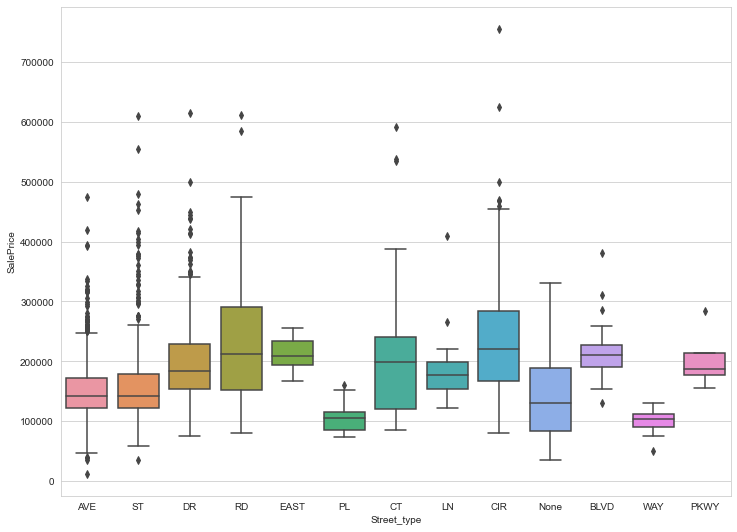

<IPython.core.display.Javascript object>

In [25]:
# looking at the relationship Street_type has on SalePrice
sns.set_style("whitegrid")
plt.figure(figsize=(12, 9))
sns.boxplot(x="Street_type", y="SalePrice", data=locations)

In [28]:
# for each group, we see that some Street_type groups, like CIR and RD, have relatively high standard
# deviations. This means that the SalePrice values for these groups are more variable or spread out,
# and there is more variability among the SalePrice values within each group. On the other hand,
# some groups like PKWY and WAY have lower standard deviations, which indicates that the SalePrice
# values for these groups are more clustered around the mean. In other words, there is less variability
# among the SalePrice values within each group and the SalePrice values tend to be closer to the mean.

locations.groupby("Street_type")["SalePrice"].agg(
    ["mean", "count", "std", "min", "max"]
)


mean  count            std     min     max
Street_type                                                     
AVE          150315.447126    870   50314.412886   12789  475000
BLVD         213474.489796     49   39912.451225  130000  381000
CIR          240307.721088    147  102140.274083   80000  755000
CT           203353.825000     80  102860.415078   85000  591587
DR           197196.396197    631   65622.104529   75000  615000
EAST         212362.500000      8   29156.618337  167900  255000
LN           188373.684211     19   64539.590280  122000  410000
None         155744.550000     20   94327.058827   34900  330000
PKWY         203612.500000      4   56212.252149  155000  284700
PL           105808.064516     31   23101.515451   73000  160250
RD           233157.621891    201   95074.286903   80000  611657
ST           160895.136905    504   69965.378418   35311  610000
WAY           99830.000000     15   19748.614780   50000  129850

<IPython.core.display.Javascript object>

In [267]:
locations

PID  SalePrice Neighborhood                      Prop_Addr  \
0     909176150     126000        SWISU     436 HAYWARD AVE, AMES, USA   
1     905476230     139500      Edwards        3416 WEST ST, AMES, USA   
3     911128020     124900       IDOTRR        320 S 2ND ST, AMES, USA   
4     535377150     114000      OldTown    1524 DOUGLAS AVE, AMES, USA   
5     534177230     227000       NWAmes   2304 FILLMORE AVE, AMES, USA   
...         ...        ...          ...                            ...   
2618  903205040     121000      BrkSide  1021 RIDGEWOOD AVE, AMES, USA   
2619  905402060     139600      Edwards       3619 MARY CIR, AMES, USA   
2620  909275030     145000      Crawfor      2140 SUNSET DR, AMES, USA   
2621  907192040     217500      CollgCr   5319 CLEMENS BLVD, AMES, USA   
2622  906223180     215000      SawyerW     1025 VERMONT CT, AMES, USA   

       Latitude  Longitude    Street_name        Neighborhood_st Street_type  
0     42.017814 -93.651428    HAYWARD_AVE      SWISU_HAYWARD_AVE         AVE  
1     42.024709 -93.664168        WEST_ST        Edwards_WEST_ST          ST  
3     42.021406 -93.614914       S_2ND_ST        IDOTRR_S_2ND_ST          ST  
4     42.038088 -93.612085    DOUGLAS_AVE    OldTown_DOUGLAS_AVE         AVE  
5     42.044900 -93.631893   FILLMORE_AVE    NWAmes_FILLMORE_AVE         AVE  
...         ...        ...            ...                    ...         ...  
2618  42.031974 -93.626550  RIDGEWOOD_AVE  BrkSide_RIDGEWOOD_AVE         AVE  
2619  42.027835 -93.666939       MARY_CIR       Edwards_MARY_CIR         CIR  
2620  42.019950 -93.643194      SUNSET_DR      Crawfor_SUNSET_DR          DR  
2621  42.016808 -93.690395   CLEMENS_BLVD   CollgCr_CLEMENS_BLVD        BLVD  
2622  42.031659 -93.682462     VERMONT_CT     SawyerW_VERMONT_CT          CT  

[2579 rows x 9 columns]

<IPython.core.display.Javascript object>

In [269]:
locations.to_csv("data/locations.csv", index=False)

<IPython.core.display.Javascript object>

In [5]:
locations = pd.read_csv("data/locations.csv")

<IPython.core.display.Javascript object>

In [12]:
# taking a look at the relationship the street in a neighborhood with the SalePrice

# group by neighborhood and street
grouped = locations.groupby(["Neighborhood", "Street_name"])

# calculate count, mean, min, and max of SalePrice for each group
result = grouped.agg({"SalePrice": ["count", "mean", "min", "max"]})

# flatten the resulting column names
result.columns = ["_".join(col).strip() for col in result.columns.values]

# reset the index to make Neighborhood and street_name columns
result = result.reset_index()

# convert SalePrice_mean to float
result["SalePrice_mean"] = result["SalePrice_mean"].astype(int)


# view the results
result

Neighborhood         Street_name  SalePrice_count  SalePrice_mean  \
0        Blmngtn        BRICKMAN_AVE                3          166698   
1        Blmngtn         LAKESIDE_DR                5          213448   
2        Blmngtn         WESTWIND_DR               15          196408   
3        Blueste  LITTLE_BLUESTEM_CT               10          143590   
4         BrDale          BARKLEY_CT                8          102112   
..           ...                 ...              ...             ...   
507      Veenker       GREENSBORO_DR                2          241875   
508      Veenker          KINGMAN_RD                5          308800   
509      Veenker       PINEHURST_CIR                3          203833   
510      Veenker    TORREY_PINES_CIR                1          218000   
511      Veenker     TORREY_PINES_RD                3          203366   

     SalePrice_min  SalePrice_max  
0           159895         180000  
1           185485         246578  
2           160000         246990  
3           115000         200000  
4            85400         122500  
..             ...            ...  
507         165000         318750  
508         192000         385000  
509         162500         255000  
510         218000         218000  
511         181500         241600  

[512 rows x 6 columns]

<IPython.core.display.Javascript object>

In [7]:
# over 500 value counts in a dataset with 2500 observations.  Looks like this feature will probally overfit
# the training data if used
locations["Neighborhood_st"].value_counts()

CollgCr_CLEMENS_BLVD     28
Gilbert_WELBECK_DR       25
NAmes_CLARK_AVE          22
BrkSide_RIDGEWOOD_AVE    22
NridgHt_HARRISON_RD      20
                         ..
StoneBr_WOODHAVEN_CIR     1
BrkSide_13TH_ST           1
NWAmes_HOOVER_AVE         1
NoRidge_GOLDENROD_CIR     1
NoRidge_HEMLOCK_CIR       1
Name: Neighborhood_st, Length: 512, dtype: int64

<IPython.core.display.Javascript object>

In [9]:
# The same with street name
locations["Street_name"].value_counts()

CLARK_AVE           38
CARROLL_AVE         29
EISENHOWER_AVE      28
NORTHWESTERN_AVE    28
CLEMENS_BLVD        28
                    ..
WESTFIELD_RD         1
ROOSEVELT_CIR        1
CRESCENT_ST          1
ARTHUR_CIR           1
HEMLOCK_CIR          1
Name: Street_name, Length: 444, dtype: int64

<IPython.core.display.Javascript object>

In [ ]:
# some map features that seem to change the house price
# locations = ['Northridge Heights Park',
#              'Ada Hayden Heritage Park',
#              'Munn Woods',
#              'Pammel Woods',
#              'Emma McCarthy Park',
#              'Jack Trice Stadium',
#              'Ames Municipal Cemetery',
#              'Carr Park',
#              'Inis Grove Park',
#              'Charles and June Calhoun Park',
#              'Ada Hayden Heritage Park Lake',
#              'North Grand Mall',
#              'Donald and Ruth Furman Aquatic Center']

In [19]:
# Looked at the map created earlier and took note of several locations that seemed to affect the sale price

from haversine import haversine

# Creating the coordinates of negative locations and positive locations
neg_locs = [('North Grand Mall', (42.049408, -93.609140)),
            ('Donald and Ruth Furman Aquatic Center', (42.011550, -93.635771)),
            ('Ames Municipal Cemetery', (42.033434, -93.616420))]
pos_locs = [('Jack Trice Stadium', (42.013916, -93.635853)),
            ('Ada Hayden Heritage Park', (42.073107, -93.684882)),
            ('Charles and June Calhoun Park', (42.033966, -93.649235))]



# Creating a function to calculate distances to negative and positive locations
def calc_distances(row):
    lat1, lon1 = row['Latitude'], row['Longitude']
    neg_distances = [haversine((lat1, lon1), loc[1]) for loc in neg_locs]
    pos_distances = [haversine((lat1, lon1), loc[1]) for loc in pos_locs]
    row['Neg_Loc_Dist'] = min(neg_distances)
    row['Pos_Loc_Dist'] = min(pos_distances)
    return row

# Applying the function to each row of the dataframe and save the results
locations = locations.apply(calc_distances, axis=1)

locations




PID  SalePrice Neighborhood                      Prop_Addr  \
0     909176150     126000        SWISU     436 HAYWARD AVE, AMES, USA   
1     905476230     139500      Edwards        3416 WEST ST, AMES, USA   
2     911128020     124900       IDOTRR        320 S 2ND ST, AMES, USA   
3     535377150     114000      OldTown    1524 DOUGLAS AVE, AMES, USA   
4     534177230     227000       NWAmes   2304 FILLMORE AVE, AMES, USA   
...         ...        ...          ...                            ...   
2574  903205040     121000      BrkSide  1021 RIDGEWOOD AVE, AMES, USA   
2575  905402060     139600      Edwards       3619 MARY CIR, AMES, USA   
2576  909275030     145000      Crawfor      2140 SUNSET DR, AMES, USA   
2577  907192040     217500      CollgCr   5319 CLEMENS BLVD, AMES, USA   
2578  906223180     215000      SawyerW     1025 VERMONT CT, AMES, USA   

       Latitude  Longitude    Street_name        Neighborhood_st Street_type  \
0     42.017814 -93.651428    HAYWARD_AVE      SWISU_HAYWARD_AVE         AVE   
1     42.024709 -93.664168        WEST_ST        Edwards_WEST_ST          ST   
2     42.021406 -93.614914       S_2ND_ST        IDOTRR_S_2ND_ST          ST   
3     42.038088 -93.612085    DOUGLAS_AVE    OldTown_DOUGLAS_AVE         AVE   
4     42.044900 -93.631893   FILLMORE_AVE    NWAmes_FILLMORE_AVE         AVE   
...         ...        ...            ...                    ...         ...   
2574  42.031974 -93.626550  RIDGEWOOD_AVE  BrkSide_RIDGEWOOD_AVE         AVE   
2575  42.027835 -93.666939       MARY_CIR       Edwards_MARY_CIR         CIR   
2576  42.019950 -93.643194      SUNSET_DR      Crawfor_SUNSET_DR          DR   
2577  42.016808 -93.690395   CLEMENS_BLVD   CollgCr_CLEMENS_BLVD        BLVD   
2578  42.031659 -93.682462     VERMONT_CT     SawyerW_VERMONT_CT          CT   

      Neg_Loc_Dist  Pos_Loc_Dist  
0         1.469070      1.357705  
1         2.764819      1.606532  
2         1.343171      1.919875  
3         0.629324      3.102195  
4         1.805101      1.878609  
...            ...           ...  
2574      0.852223      1.886661  
2575      3.147736      1.613317  
2576      1.117355      0.904408  
2577      4.550501      3.898603  
2578      4.458274      2.756261  

[2579 rows x 11 columns]

<IPython.core.display.Javascript object>

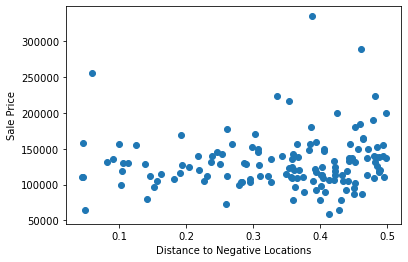

Correlation coefficient: 0.08243886574413524


<IPython.core.display.Javascript object>

In [20]:
# Taking a look to see if the negative locations affect the sale price


# filter the locations dataframe to only include observations that are less than 0.5 miles away from negative locations
locations_filtered = locations[(locations["Neg_Loc_Dist"] < 0.5)]


# create a scatter plot of Neg_Loc_Dist vs SalePrice
plt.scatter(locations_filtered["Neg_Loc_Dist"], locations_filtered["SalePrice"])
plt.xlabel("Distance to Negative Locations")
plt.ylabel("Sale Price")
plt.show()

# calculate the correlation between Neg_Loc_Dist and SalePrice
corr_coef = locations_filtered["Neg_Loc_Dist"].corr(locations_filtered["SalePrice"])
print("Correlation coefficient:", corr_coef)

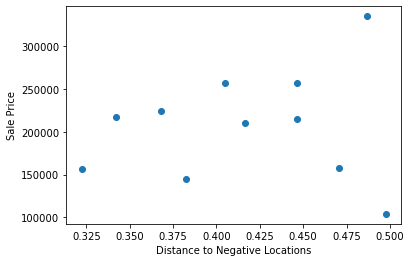

Correlation coefficient: 0.11722799927660844


<IPython.core.display.Javascript object>

In [21]:
# doing the same with positive locations

#  filter the locations dataframe to only include observations that are less than 0.5 miles away from negative locations
locations_filtered = locations[(locations["Pos_Loc_Dist"] < 0.5)]


# create a scatter plot of Neg_Loc_Dist vs SalePrice
plt.scatter(locations_filtered["Pos_Loc_Dist"], locations_filtered["SalePrice"])
plt.xlabel("Distance to Negative Locations")
plt.ylabel("Sale Price")
plt.show()

# calculate the correlation between Neg_Loc_Dist and SalePrice
corr_coef = locations_filtered["Pos_Loc_Dist"].corr(locations_filtered["SalePrice"])
print("Correlation coefficient:", corr_coef)

In [31]:
# looks like there is a strong correlation between SalePrice and the street it is on.  Ill group them into
# different groups since there are too many street names

# Creating a function to put street into different groups

def group_streets_by_saleprice(df, num_quantiles=4):
    # Calculate the mean sale price for each street
    street_prices = df.groupby('Street_name')['SalePrice'].mean()
    # Group the streets into the specified number of quantiles based on sale price
    labels = [f'group_{i+1}' for i in range(num_quantiles)]
    groups = pd.qcut(street_prices, q=num_quantiles, labels=labels)
    # Create a dictionary that maps each street name to its corresponding sale price group label
    street_group_dict = dict(zip(street_prices.index, groups))
    return street_group_dict


# Apply the function to create a dictionary for 10 quantiles
street_group_dict_10q = group_streets_by_saleprice(locations, num_quantiles=10)

# Apply the function to create a dictionary for 20 quantiles
street_group_dict_20q = group_streets_by_saleprice(locations, num_quantiles=20)

# Apply the function to create a dictionary for 30 quantiles
street_group_dict_30q = group_streets_by_saleprice(locations, num_quantiles=30)

# Apply the function to create a dictionary for 50 quantiles
street_group_dict_50q = group_streets_by_saleprice(locations, num_quantiles=50)



<IPython.core.display.Javascript object>

In [35]:
# adding them to the locations df

locations['Street_10_Quantiles'] = locations['Street_name'].map(street_group_dict_10q)

locations["Street_20_Quantiles"] = locations["Street_name"].map(street_group_dict_20q)

locations['Street_30_Quantiles'] = locations['Street_name'].map(street_group_dict_30q)

locations["Street_50_Quantiles"] = locations["Street_name"].map(street_group_dict_50q)



<IPython.core.display.Javascript object>

In [50]:
# there shouldnt be any missing values but am double checking

print(locations[['Street_10_Quantiles', 'Street_20_Quantiles', 'Street_30_Quantiles', 'Street_50_Quantiles']].isna().any())


Street_10_Quantiles    False
Street_20_Quantiles    False
Street_30_Quantiles    False
Street_50_Quantiles    False
dtype: bool


<IPython.core.display.Javascript object>

In [64]:
# checknig on unique saleprices
unique_prices = len(locations['SalePrice'].unique())
print("Number of unique SalePrice values:", unique_prices)


Number of unique SalePrice values: 870


<IPython.core.display.Javascript object>

In [47]:
# Looks like 50 is the highest I should break them into

locations['Street_50_Quantiles'].value_counts()


group_12    139
group_9     107
group_33     83
group_18     81
group_7      74
group_22     72
group_35     68
group_43     67
group_17     66
group_20     66
group_32     66
group_13     63
group_14     61
group_24     61
group_29     60
group_37     59
group_11     58
group_6      57
group_31     56
group_16     55
group_23     53
group_15     52
group_41     52
group_5      51
group_44     50
group_34     49
group_10     49
group_30     49
group_39     47
group_4      43
group_3      43
group_8      42
group_28     41
group_48     40
group_49     40
group_26     38
group_47     37
group_25     35
group_38     34
group_19     33
group_21     33
group_27     32
group_40     31
group_45     30
group_36     29
group_46     29
group_2      28
group_42     26
group_1      24
group_50     20
Name: Street_50_Quantiles, dtype: int64

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Street_30_Quantiles', ylabel='SalePrice'>

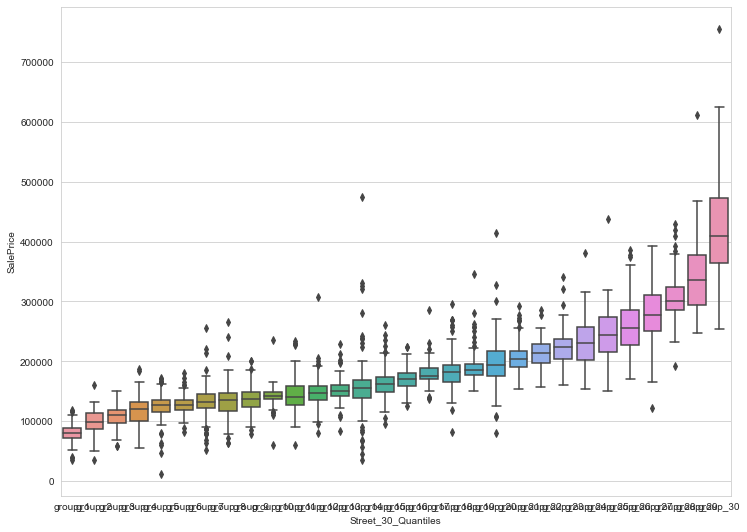

<IPython.core.display.Javascript object>

In [43]:
# calculate the mean SalePrice for each Street_50_Quantiles group
quantiles_means = locations.groupby("Street_50_Quantiles")["SalePrice"].mean()

# sort the quantiles in ascending order based on the mean SalePrice
sorted_quantiles = quantiles_means.sort_values().index

# plot the boxplot with the sorted order
sns.set_style("whitegrid")
plt.figure(figsize=(12, 9))
sns.boxplot(x="Street_30_Quantiles", y="SalePrice", data=locations, order=sorted_quantiles)


<AxesSubplot:xlabel='Street_10_Quantiles', ylabel='SalePrice'>

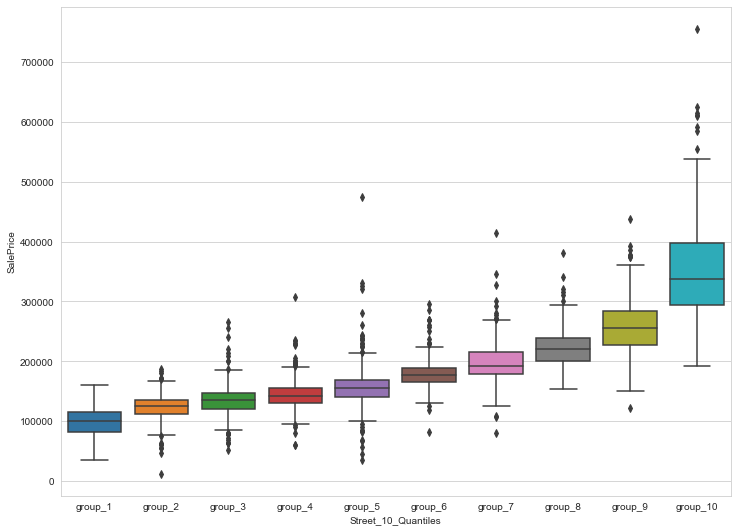

<IPython.core.display.Javascript object>

In [48]:
# calculate the mean SalePrice for each Street_50_Quantiles group
quantiles_means = locations.groupby("Street_10_Quantiles")["SalePrice"].mean()

# sort the quantiles in ascending order based on the mean SalePrice
sorted_quantiles = quantiles_means.sort_values().index

# plot the boxplot with the sorted order
sns.set_style("whitegrid")
plt.figure(figsize=(12, 9))
sns.boxplot(x="Street_10_Quantiles", y="SalePrice", data=locations, order=sorted_quantiles)


In [53]:
housing_cleaned = pd.read_csv("data/housing_cleaned.csv")
housing_cleaned

PID  GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  \
0     909176150        856     126000          30       RL          0.0   
1     905476230       1049     139500         120       RL         42.0   
2     911128020       1001     124900          30  C (all)         60.0   
3     535377150       1039     114000          70       RL         80.0   
4     534177230       1665     227000          60       RL         70.0   
...         ...        ...        ...         ...      ...          ...   
2577  903205040        952     121000          30       RL          0.0   
2578  905402060       1733     139600          20       RL          0.0   
2579  909275030       2002     145000          90       RH         82.0   
2580  907192040       1842     217500          60       RL          0.0   
2581  906223180       1911     215000          60       RL         80.0   

      LotArea Street     Alley LotShape LandContour Utilities LotConfig  \
0        7890   Pave  No_Alley      Reg         Lvl    AllPub    Corner   
1        4235   Pave  No_Alley      Reg         Lvl    AllPub    Inside   
2        6060   Pave  No_Alley      Reg         Lvl    AllPub    Inside   
3        8146   Pave  No_Alley      Reg         Lvl    AllPub    Corner   
4        8400   Pave  No_Alley      Reg         Lvl    AllPub    Inside   
...       ...    ...       ...      ...         ...       ...       ...   
2577     8854   Pave  No_Alley      Reg         Lvl    AllPub    Inside   
2578    13680   Pave  No_Alley      IR1         Lvl    AllPub   CulDSac   
2579     6270   Pave  No_Alley      Reg         HLS    AllPub    Inside   
2580     8826   Pave  No_Alley      Reg         Lvl    AllPub    Inside   
2581     9554   Pave  No_Alley      IR1         Lvl    AllPub    Inside   

     LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
0          Gtl        SWISU       Norm       Norm     1Fam     1Story   
1          Gtl      Edwards       Norm       Norm   TwnhsE     1Story   
2          Gtl       IDOTRR       Norm       Norm     1Fam     1Story   
3          Gtl      OldTown       Norm       Norm     1Fam     2Story   
4          Gtl       NWAmes       Norm       Norm     1Fam     2Story   
...        ...          ...        ...        ...      ...        ...   
2577       Gtl      BrkSide       Norm       Norm     1Fam     1.5Unf   
2578       Gtl      Edwards       Norm       Norm     1Fam     1Story   
2579       Gtl      Crawfor       Norm       Norm   Duplex     2Story   
2580       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
2581       Gtl      SawyerW       Norm       Norm     1Fam     2Story   

      OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl  \
0               6            6       1939          1950     Gable  CompShg   
1               5            5       1984          1984     Gable  CompShg   
2               5            9       1930          2007       Hip  CompShg   
3               4            8       1900          2003     Gable  CompShg   
4               8            6       2001          2001     Gable  CompShg   
...           ...          ...        ...           ...       ...      ...   
2577            6            6       1916          1950     Gable  CompShg   
2578            3            5       1955          1955       Hip  CompShg   
2579            5            6       1949          1950     Gable  CompShg   
2580            7            5       2000          2000     Gable  CompShg   
2581            8            5       1993          1994     Gable  CompShg   

     Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond  \
0        Wd Sdng     Wd Sdng       None         0.0        TA        TA   
1        HdBoard     HdBoard    BrkFace       149.0        Gd        TA   
2        MetalSd     MetalSd       None         0.0        Gd        TA   
3        MetalSd     MetalSd       None         0.0        Gd        Gd   
4        VinylSd     

<IPython.core.display.Javascript object>

In [60]:
locations.shape

(2579, 15)

<IPython.core.display.Javascript object>

In [61]:
housing_cleaned.shape

(2582, 83)

<IPython.core.display.Javascript object>

In [65]:
housing_cleaned[housing_cleaned.duplicated(subset=["PID"], keep=False)]

PID  GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  \
1816  909276070       1717     194000          50       RL         80.0   
1817  909276070       1717     194000          50       RL         80.0   
1818  909276070       1717     194000          50       RL         80.0   
1819  909276070       1717     194000          50       RL         80.0   

      LotArea Street     Alley LotShape LandContour Utilities LotConfig  \
1816    12400   Pave  No_Alley      Reg         HLS    AllPub    Inside   
1817    12400   Pave  No_Alley      Reg         HLS    AllPub    Inside   
1818    12400   Pave  No_Alley      Reg         HLS    AllPub    Inside   
1819    12400   Pave  No_Alley      Reg         HLS    AllPub    Inside   

     LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
1816       Mod      Crawfor       Norm       Norm     1Fam     1.5Fin   
1817       Mod      Crawfor       Norm       Norm     1Fam     1.5Fin   
1818       Mod      Crawfor       Norm       Norm     1Fam     1.5Fin   
1819       Mod      Crawfor       Norm       Norm     1Fam     1.5Fin   

      OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl  \
1816            5            6       1940          1950     Gable  CompShg   
1817            5            6       1940          1950     Gable  CompShg   
1818            5            6       1940          1950     Gable  CompShg   
1819            5            6       1940          1950     Gable  CompShg   

     Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond  \
1816     Wd Sdng     Wd Sdng       None         0.0        TA        TA   
1817     Wd Sdng     Wd Sdng       None         0.0        TA        TA   
1818     Wd Sdng     Wd Sdng       None         0.0        TA        TA   
1819     Wd Sdng     Wd Sdng       None         0.0        TA        TA   

     Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1  \
1816     CBlock       Gd       TA           Mn          BLQ       602.0   
1817     CBlock       Gd       TA           Mn          BLQ       602.0   
1818     CBlock       Gd       TA           Mn          BLQ       602.0   
1819     CBlock       Gd       TA           Mn          BLQ       602.0   

     BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC  \
1816          Unf         0.0      299.0        901.0    GasA        TA   
1817          Unf         0.0      299.0        901.0    GasA        TA   
1818          Unf         0.0      299.0        901.0    GasA        TA   
1819          Unf         0.0      299.0        901.0    GasA        TA   

     CentralAir Electrical  1stFlrSF  2ndFlrSF  BsmtFullBath  BsmtHalfBath  \
1816          Y      SBrkr      1125       592           0.0           0.0   
1817          Y      SBrkr      1125       592           0.0           0.0   
1818          Y      SBrkr      1125       592           0.0           0.0   
1819          Y      SBrkr      1125       592           0.0           0.0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
1816         1         1             2             1          TA   
1817         1         1             2             1          TA   
1818         1         1             2             1          TA   
1819         1         1             2             1          TA   

      TotRmsAbvGrd Functional  Fireplaces FireplaceQu GarageType  GarageYrBlt  \
1816             7        Typ           1          Gd     Attchd       1940.0   
1817             7        Typ           1          Gd     Attchd       1940.0   
1818             7        Typ           1          Gd     Attchd       1940.0   
1819             7        Typ           1          Gd     Attchd       1940.0   

     GarageFinish  GarageCars  GarageArea GarageQual GarageCond PavedDrive  \
1816          Unf         1.0       410.0         TA         TA          Y   
1817          Unf         1.0       410.0         TA         TA          Y   
181

<IPython.core.display.Javascript object>

In [66]:
# drop rows with index numbers 1817, 1818, and 1819 from housing_cleaned
housing_cleaned = housing_cleaned.drop([1817, 1818, 1819])

# verify that the rows have been deleted
housing_cleaned.loc[1817:1820]


            PID  GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  \
1820  534278190        894     117600          20       RL         70.0   

      LotArea Street     Alley LotShape LandContour Utilities LotConfig  \
1820     8680   Pave  No_Alley      Reg         Lvl    AllPub    Inside   

     LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
1820       Gtl        NAmes       Norm       Norm     1Fam     1Story   

      OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl  \
1820            5            7       1960          1960       Hip  CompShg   

     Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond  \
1820     CemntBd     CmentBd       None         0.0        TA        TA   

     Foundation BsmtQual BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1  \
1820     CBlock       TA       TA           No          Unf         0.0   

     BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF Heating HeatingQC  \
1820          Unf

<IPython.core.display.Javascript object>

In [68]:
# reset the index of housing_cleaned
housing_cleaned = housing_cleaned.reset_index(drop=True)

<IPython.core.display.Javascript object>

In [69]:
# adding the promising features to housing_cleaned
housing_cleaned = pd.merge(housing_cleaned, locations[['PID', 'Street_type', 'Street_10_Quantiles', 'Street_20_Quantiles', 'Street_30_Quantiles', 'Street_50_Quantiles']], on='PID', how='left')


<IPython.core.display.Javascript object>

In [82]:
# decided to add Prop_Addr and Street_name as well in case i want to get a better understanding of outliers in each group 
housing_cleaned = pd.merge(housing_cleaned, locations[['PID', 'Prop_Addr']], on='PID', how='left')

housing_cleaned = pd.merge(
    housing_cleaned, locations[["PID", "Street_name"]], on="PID", how="left"
)


<IPython.core.display.Javascript object>

In [81]:
housing_cleaned

PID  GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  \
0     909176150        856     126000          30       RL          0.0   
1     905476230       1049     139500         120       RL         42.0   
2     911128020       1001     124900          30  C (all)         60.0   
3     535377150       1039     114000          70       RL         80.0   
4     534177230       1665     227000          60       RL         70.0   
...         ...        ...        ...         ...      ...          ...   
2574  903205040        952     121000          30       RL          0.0   
2575  905402060       1733     139600          20       RL          0.0   
2576  909275030       2002     145000          90       RH         82.0   
2577  907192040       1842     217500          60       RL          0.0   
2578  906223180       1911     215000          60       RL         80.0   

      LotArea Street     Alley LotShape LandContour Utilities LotConfig  \
0        7890   Pave  No_Alley      Reg         Lvl    AllPub    Corner   
1        4235   Pave  No_Alley      Reg         Lvl    AllPub    Inside   
2        6060   Pave  No_Alley      Reg         Lvl    AllPub    Inside   
3        8146   Pave  No_Alley      Reg         Lvl    AllPub    Corner   
4        8400   Pave  No_Alley      Reg         Lvl    AllPub    Inside   
...       ...    ...       ...      ...         ...       ...       ...   
2574     8854   Pave  No_Alley      Reg         Lvl    AllPub    Inside   
2575    13680   Pave  No_Alley      IR1         Lvl    AllPub   CulDSac   
2576     6270   Pave  No_Alley      Reg         HLS    AllPub    Inside   
2577     8826   Pave  No_Alley      Reg         Lvl    AllPub    Inside   
2578     9554   Pave  No_Alley      IR1         Lvl    AllPub    Inside   

     LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
0          Gtl        SWISU       Norm       Norm     1Fam     1Story   
1          Gtl      Edwards       Norm       Norm   TwnhsE     1Story   
2          Gtl       IDOTRR       Norm       Norm     1Fam     1Story   
3          Gtl      OldTown       Norm       Norm     1Fam     2Story   
4          Gtl       NWAmes       Norm       Norm     1Fam     2Story   
...        ...          ...        ...        ...      ...        ...   
2574       Gtl      BrkSide       Norm       Norm     1Fam     1.5Unf   
2575       Gtl      Edwards       Norm       Norm     1Fam     1Story   
2576       Gtl      Crawfor       Norm       Norm   Duplex     2Story   
2577       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
2578       Gtl      SawyerW       Norm       Norm     1Fam     2Story   

      OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl  \
0               6            6       1939          1950     Gable  CompShg   
1               5            5       1984          1984     Gable  CompShg   
2               5            9       1930          2007       Hip  CompShg   
3               4            8       1900          2003     Gable  CompShg   
4               8            6       2001          2001     Gable  CompShg   
...           ...          ...        ...           ...       ...      ...   
2574            6            6       1916          1950     Gable  CompShg   
2575            3            5       1955          1955       Hip  CompShg   
2576            5            6       1949          1950     Gable  CompShg   
2577            7            5       2000          2000     Gable  CompShg   
2578            8            5       1993          1994     Gable  CompShg   

     Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond  \
0        Wd Sdng     Wd Sdng       None         0.0        TA        TA   
1        HdBoard     HdBoard    BrkFace       149.0        Gd        TA   
2        MetalSd     MetalSd       None         0.0        Gd        TA   
3        MetalSd     MetalSd       None         0.0        Gd        Gd   
4        VinylSd     

<IPython.core.display.Javascript object>

In [72]:
housing_cleaned.to_csv("data/housing_cleaned", index=False)

<IPython.core.display.Javascript object>

In [73]:
locations.to_csv("data/locations", index=False)

<IPython.core.display.Javascript object>

In [86]:
# saving wasnt saving my changes so ill force encoding

# save the updated dataframe as a CSV file with UTF-8 encoding
housing_cleaned.to_csv('data/housing_cleaned.csv', index=False, encoding='utf-8')


<IPython.core.display.Javascript object>

In [75]:
# saving wasnt saving my changes so ill force encoding

# save the updated dataframe as a CSV file with UTF-8 encoding
locations.to_csv('data/locations.csv', index=False, encoding='utf-8')



<IPython.core.display.Javascript object>

In [ ]:
# reload the CSV file with UTF-8 encoding
locations = pd.read_csv('data/locations.csv', encoding='utf-8')

<IPython.core.display.Javascript object>

In [132]:
df = pd.read_csv("data/locations.csv")

<IPython.core.display.Javascript object>

In [133]:
# I'm going to remove the observations with missing locations since they will skew the results.

# dropping columns that will be replaced
df.drop(
    columns=[
        "Street_10_Quantiles",
        "Street_20_Quantiles",
        "Street_30_Quantiles",
        "Street_50_Quantiles",
    ],
    inplace=True,
)
df

PID  SalePrice Neighborhood                      Prop_Addr  \
0     909176150     126000        SWISU     436 HAYWARD AVE, AMES, USA   
1     905476230     139500      Edwards        3416 WEST ST, AMES, USA   
2     911128020     124900       IDOTRR        320 S 2ND ST, AMES, USA   
3     535377150     114000      OldTown    1524 DOUGLAS AVE, AMES, USA   
4     534177230     227000       NWAmes   2304 FILLMORE AVE, AMES, USA   
...         ...        ...          ...                            ...   
2574  903205040     121000      BrkSide  1021 RIDGEWOOD AVE, AMES, USA   
2575  905402060     139600      Edwards       3619 MARY CIR, AMES, USA   
2576  909275030     145000      Crawfor      2140 SUNSET DR, AMES, USA   
2577  907192040     217500      CollgCr   5319 CLEMENS BLVD, AMES, USA   
2578  906223180     215000      SawyerW     1025 VERMONT CT, AMES, USA   

       Latitude  Longitude    Street_name        Neighborhood_st Street_type  \
0     42.017814 -93.651428    HAYWARD_AVE      SWISU_HAYWARD_AVE         AVE   
1     42.024709 -93.664168        WEST_ST        Edwards_WEST_ST          ST   
2     42.021406 -93.614914       S_2ND_ST        IDOTRR_S_2ND_ST          ST   
3     42.038088 -93.612085    DOUGLAS_AVE    OldTown_DOUGLAS_AVE         AVE   
4     42.044900 -93.631893   FILLMORE_AVE    NWAmes_FILLMORE_AVE         AVE   
...         ...        ...            ...                    ...         ...   
2574  42.031974 -93.626550  RIDGEWOOD_AVE  BrkSide_RIDGEWOOD_AVE         AVE   
2575  42.027835 -93.666939       MARY_CIR       Edwards_MARY_CIR         CIR   
2576  42.019950 -93.643194      SUNSET_DR      Crawfor_SUNSET_DR          DR   
2577  42.016808 -93.690395   CLEMENS_BLVD   CollgCr_CLEMENS_BLVD        BLVD   
2578  42.031659 -93.682462     VERMONT_CT     SawyerW_VERMONT_CT          CT   

      Neg_Loc_Dist  Pos_Loc_Dist  
0         1.469070      1.357705  
1         2.764819      1.606532  
2         1.343171      1.919875  
3         0.629324      3.102195  
4         1.805101      1.878609  
...            ...           ...  
2574      0.852223      1.886661  
2575      3.147736      1.613317  
2576      1.117355      0.904408  
2577      4.550501      3.898603  
2578      4.458274      2.756261  

[2579 rows x 11 columns]

<IPython.core.display.Javascript object>

In [134]:


# selecting rows where Street_type is "None"
rows_to_drop = df[locations["Street_type"] == "None"].index

# dropping the selected rows from the DataFrame
df.drop(index=rows_to_drop, inplace=True)


<IPython.core.display.Javascript object>

In [136]:
# this time i creating a function to rank the streets with numbers instead of groups since houses on one 
# street are better than houses on another street. Im using the retbins=True parameter to return the bin
# edges so I can use them later to determine which group each street falls into


def group_streets_by_saleprice_num(df, num_quantiles=4):
    # Calculate the mean sale price for each street
    street_prices = df.groupby('Street_name')['SalePrice'].mean()
    # Group the streets into the specified number of quantiles based on sale price
    groups, bins = pd.qcut(street_prices, q=num_quantiles, labels=False, retbins=True)
    # Create a dictionary that maps each street name to its corresponding sale price group label
    street_group_dict = {}
    for i, street in enumerate(street_prices.index):
        for j, bin_edge in enumerate(bins[:-1]):
            if street_prices[street] >= bin_edge and street_prices[street] <= bins[j+1]:
                street_group_dict[street] = j+1
    return street_group_dict


<IPython.core.display.Javascript object>

In [137]:
# Apply the function to create a dictionary for 10 quantiles
street_group_dict_10q = group_streets_by_saleprice_num(df, num_quantiles=10)

# Apply the function to create a dictionary for 20 quantiles
street_group_dict_20q = group_streets_by_saleprice_num(df, num_quantiles=20)

# Apply the function to create a dictionary for 30 quantiles
street_group_dict_30q = group_streets_by_saleprice_num(df, num_quantiles=30)

# Apply the function to create a dictionary for 50 quantiles
street_group_dict_50q = group_streets_by_saleprice_num(df, num_quantiles=50)

<IPython.core.display.Javascript object>

In [138]:
# adding them to the locations df

df["Street_10_Quantiles"] = df["Street_name"].map(street_group_dict_10q)

df["Street_20_Quantiles"] = df["Street_name"].map(street_group_dict_20q)

df["Street_30_Quantiles"] = df["Street_name"].map(street_group_dict_30q)

df["Street_50_Quantiles"] = df["Street_name"].map(street_group_dict_50q)

<IPython.core.display.Javascript object>

In [139]:
df

PID  SalePrice Neighborhood                      Prop_Addr  \
0     909176150     126000        SWISU     436 HAYWARD AVE, AMES, USA   
1     905476230     139500      Edwards        3416 WEST ST, AMES, USA   
2     911128020     124900       IDOTRR        320 S 2ND ST, AMES, USA   
3     535377150     114000      OldTown    1524 DOUGLAS AVE, AMES, USA   
4     534177230     227000       NWAmes   2304 FILLMORE AVE, AMES, USA   
...         ...        ...          ...                            ...   
2574  903205040     121000      BrkSide  1021 RIDGEWOOD AVE, AMES, USA   
2575  905402060     139600      Edwards       3619 MARY CIR, AMES, USA   
2576  909275030     145000      Crawfor      2140 SUNSET DR, AMES, USA   
2577  907192040     217500      CollgCr   5319 CLEMENS BLVD, AMES, USA   
2578  906223180     215000      SawyerW     1025 VERMONT CT, AMES, USA   

       Latitude  Longitude    Street_name        Neighborhood_st Street_type  \
0     42.017814 -93.651428    HAYWARD_AVE      SWISU_HAYWARD_AVE         AVE   
1     42.024709 -93.664168        WEST_ST        Edwards_WEST_ST          ST   
2     42.021406 -93.614914       S_2ND_ST        IDOTRR_S_2ND_ST          ST   
3     42.038088 -93.612085    DOUGLAS_AVE    OldTown_DOUGLAS_AVE         AVE   
4     42.044900 -93.631893   FILLMORE_AVE    NWAmes_FILLMORE_AVE         AVE   
...         ...        ...            ...                    ...         ...   
2574  42.031974 -93.626550  RIDGEWOOD_AVE  BrkSide_RIDGEWOOD_AVE         AVE   
2575  42.027835 -93.666939       MARY_CIR       Edwards_MARY_CIR         CIR   
2576  42.019950 -93.643194      SUNSET_DR      Crawfor_SUNSET_DR          DR   
2577  42.016808 -93.690395   CLEMENS_BLVD   CollgCr_CLEMENS_BLVD        BLVD   
2578  42.031659 -93.682462     VERMONT_CT     SawyerW_VERMONT_CT          CT   

      Neg_Loc_Dist  Pos_Loc_Dist  Street_10_Quantiles  Street_20_Quantiles  \
0         1.469070      1.357705                    4                    7   
1         2.764819      1.606532                    2                    3   
2         1.343171      1.919875                    2                    3   
3         0.629324      3.102195                    3                    6   
4         1.805101      1.878609                    8                   15   
...            ...           ...                  ...                  ...   
2574      0.852223      1.886661                    3                    5   
2575      3.147736      1.613317                    3                    5   
2576      1.117355      0.904408                    4                    8   
2577      4.550501      3.898603                    8                   15   
2578      4.458274      2.756261                    8                   16   

      Street_30_Quantiles  Street_50_Quantiles  
0                      11                   17  
1                       5                    8  
2                       5                    8  
3                       8                   14  
4                      22                   36  
...                   ...                  ...  
2574                    8                   13  
2575                    7                   11  
2576                   11                   18  
2577                   22                   37  
2578                   24                   39  

[2559 rows x 15 columns]

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Street_50_Quantiles', ylabel='SalePrice'>

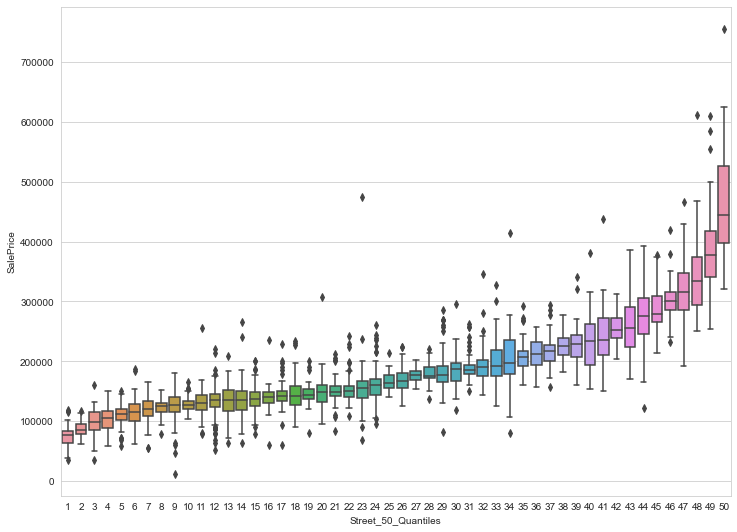

<IPython.core.display.Javascript object>

In [140]:
# calculate the mean SalePrice for each Street_50_Quantiles group
quantiles_means = df.groupby("Street_50_Quantiles")["SalePrice"].mean()

# sort the quantiles in ascending order based on the mean SalePrice
sorted_quantiles = quantiles_means.sort_values().index

# plot the boxplot with the sorted order
sns.set_style("whitegrid")
plt.figure(figsize=(12, 9))
sns.boxplot(x="Street_50_Quantiles", y="SalePrice", data=df, order=sorted_quantiles)

<AxesSubplot:xlabel='Street_10_Quantiles', ylabel='SalePrice'>

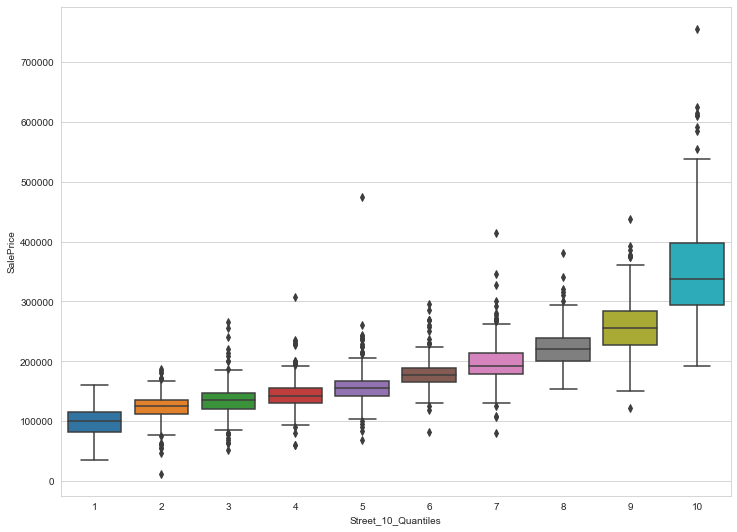

<IPython.core.display.Javascript object>

In [141]:
# calculate the mean SalePrice for each Street_50_Quantiles group
quantiles_means = df.groupby("Street_10_Quantiles")["SalePrice"].mean()

# sort the quantiles in ascending order based on the mean SalePrice
sorted_quantiles = quantiles_means.sort_values().index

# plot the boxplot with the sorted order
sns.set_style("whitegrid")
plt.figure(figsize=(12, 9))
sns.boxplot(x="Street_10_Quantiles", y="SalePrice", data=df, order=sorted_quantiles)

In [160]:
housing = pd.read_csv("data/housing_cleaned.csv")


<IPython.core.display.Javascript object>

In [161]:
# dropping columns that will be replaced
housing.drop(
    columns=[
        "Street_10_Quantiles",
        "Street_20_Quantiles",
        "Street_30_Quantiles",
        "Street_50_Quantiles",
    ],
    inplace=True,
)


<IPython.core.display.Javascript object>

In [162]:
# selecting rows where Street_type is "None"
rows_to_drop = housing[housing["Street_type"] == "None"].index

# dropping the selected rows from the DataFrame
housing.drop(index=rows_to_drop, inplace=True)

<IPython.core.display.Javascript object>

In [163]:
# adding the features
housing = pd.merge(housing, locations[['PID', 'Street_10_Quantiles', 'Street_20_Quantiles', 'Street_30_Quantiles', 'Street_50_Quantiles']], on='PID', how='left')




<IPython.core.display.Javascript object>

In [164]:
housing

PID  GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  \
0     909176150        856     126000          30       RL          0.0   
1     905476230       1049     139500         120       RL         42.0   
2     911128020       1001     124900          30  C (all)         60.0   
3     535377150       1039     114000          70       RL         80.0   
4     534177230       1665     227000          60       RL         70.0   
...         ...        ...        ...         ...      ...          ...   
2554  903205040        952     121000          30       RL          0.0   
2555  905402060       1733     139600          20       RL          0.0   
2556  909275030       2002     145000          90       RH         82.0   
2557  907192040       1842     217500          60       RL          0.0   
2558  906223180       1911     215000          60       RL         80.0   

      LotArea Street     Alley LotShape LandContour Utilities LotConfig  \
0        7890   Pave  No_Alley      Reg         Lvl    AllPub    Corner   
1        4235   Pave  No_Alley      Reg         Lvl    AllPub    Inside   
2        6060   Pave  No_Alley      Reg         Lvl    AllPub    Inside   
3        8146   Pave  No_Alley      Reg         Lvl    AllPub    Corner   
4        8400   Pave  No_Alley      Reg         Lvl    AllPub    Inside   
...       ...    ...       ...      ...         ...       ...       ...   
2554     8854   Pave  No_Alley      Reg         Lvl    AllPub    Inside   
2555    13680   Pave  No_Alley      IR1         Lvl    AllPub   CulDSac   
2556     6270   Pave  No_Alley      Reg         HLS    AllPub    Inside   
2557     8826   Pave  No_Alley      Reg         Lvl    AllPub    Inside   
2558     9554   Pave  No_Alley      IR1         Lvl    AllPub    Inside   

     LandSlope Neighborhood Condition1 Condition2 BldgType HouseStyle  \
0          Gtl        SWISU       Norm       Norm     1Fam     1Story   
1          Gtl      Edwards       Norm       Norm   TwnhsE     1Story   
2          Gtl       IDOTRR       Norm       Norm     1Fam     1Story   
3          Gtl      OldTown       Norm       Norm     1Fam     2Story   
4          Gtl       NWAmes       Norm       Norm     1Fam     2Story   
...        ...          ...        ...        ...      ...        ...   
2554       Gtl      BrkSide       Norm       Norm     1Fam     1.5Unf   
2555       Gtl      Edwards       Norm       Norm     1Fam     1Story   
2556       Gtl      Crawfor       Norm       Norm   Duplex     2Story   
2557       Gtl      CollgCr       Norm       Norm     1Fam     2Story   
2558       Gtl      SawyerW       Norm       Norm     1Fam     2Story   

      OverallQual  OverallCond  YearBuilt  YearRemodAdd RoofStyle RoofMatl  \
0               6            6       1939          1950     Gable  CompShg   
1               5            5       1984          1984     Gable  CompShg   
2               5            9       1930          2007       Hip  CompShg   
3               4            8       1900          2003     Gable  CompShg   
4               8            6       2001          2001     Gable  CompShg   
...           ...          ...        ...           ...       ...      ...   
2554            6            6       1916          1950     Gable  CompShg   
2555            3            5       1955          1955       Hip  CompShg   
2556            5            6       1949          1950     Gable  CompShg   
2557            7            5       2000          2000     Gable  CompShg   
2558            8            5       1993          1994     Gable  CompShg   

     Exterior1st Exterior2nd MasVnrType  MasVnrArea ExterQual ExterCond  \
0        Wd Sdng     Wd Sdng       None         0.0        TA        TA   
1        HdBoard     HdBoard    BrkFace       149.0        Gd        TA   
2        MetalSd     MetalSd       None         0.0        Gd        TA   
3        MetalSd     MetalSd       None         0.0        Gd        Gd   
4        VinylSd     

<IPython.core.display.Javascript object>

In [165]:
# save the updated dataframe as a CSV file with UTF-8 encoding
housing.to_csv("data/housing_drop_20.csv", index=False, encoding="utf-8")

<IPython.core.display.Javascript object>

In [149]:
# save the updated dataframe as a CSV file with UTF-8 encoding
df.to_csv("data/locations_drop_20.csv", index=False, encoding="utf-8")

<IPython.core.display.Javascript object>

In [166]:
housing[housing["Street_name"] == "None"]

Empty DataFrame
Columns: [PID, GrLivArea, SalePrice, MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, ScreenPorch, PoolQC, Fence, MoSold, YrSold, SaleType, SaleCondition, Age, RemodAge, TotalSF, Remodeled, TotalPorchSF, TotalBath, MSSubClass_cat, Street_type, Prop_Addr, Street_name, Street_10_Quantiles, Street_20_Quantiles, Street_30_Quantiles, Street_50_Quantiles]
Index: []

<IPython.core.display.Javascript object>